In [22]:
import itertools
import pandas as pd
import numpy as np
import random
import csv
import time

import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

import keras.backend as K
from keras import Sequential
from keras.layers import Dense, Dropout

In [23]:
import pandas as pd
import random
import csv

class DataGenerator():
    def __init__(self, datapath, itempath):
        self.data = self.load_datas(datapath, itempath)
        self.users = self.data['userId'].unique()
        self.items = self.data['itemId'].unique()
        self.histo = self.gen_histo()
        self.train = []
        self.test = []

    def load_datas(self, datapath, itempath):
        data = pd.read_csv(datapath, sep='\t', names=['userId', 'itemId', 'rating', 'timestamp'])
        movie_titles = pd.read_csv(itempath, sep='|', names=['itemId', 'itemName'], usecols=range(2), encoding='latin-1')
        return data.merge(movie_titles, on='itemId', how='left')

    def gen_histo(self):
        historic_users = []
        for i, u in enumerate(self.users):
            temp = self.data[self.data['userId'] == u]
            temp = temp.sort_values('timestamp').reset_index()
            temp.drop('index', axis=1, inplace=True)
            historic_users.append(temp)
        return historic_users

    def sample_histo(self, user_histo, action_ratio=0.8, max_samp_by_user=5, max_state=100, max_action=50, nb_states=[], nb_actions=[]):
        n = len(user_histo)
        sep = int(action_ratio * n)
        nb_sample = random.randint(1, max_samp_by_user)
        if not nb_states:
            nb_states = [min(random.randint(1, sep), max_state) for i in range(nb_sample)]
        if not nb_actions:
            nb_actions = [min(random.randint(1, n - sep), max_action) for i in range(nb_sample)]
        assert len(nb_states) == len(nb_actions), 'Given array must have the same size'

        states = []
        actions = []
        for i in range(len(nb_states)):
            sample_states = user_histo.iloc[0:sep].sample(nb_states[i])
            sample_actions = user_histo.iloc[-(n - sep):].sample(nb_actions[i])

            sample_state = []
            sample_action = []
            for j in range(nb_states[i]):
                row = sample_states.iloc[j]
                state = str(row.loc['itemId']) + '&' + str(row.loc['rating'])
                sample_state.append(state)

            for j in range(nb_actions[i]):
                row = sample_actions.iloc[j]
                action = str(row.loc['itemId']) + '&' + str(row.loc['rating'])
                sample_action.append(action)

            states.append(sample_state)
            actions.append(sample_action)
        return states, actions

    def gen_train_test(self, test_ratio, seed=None):
        n = len(self.histo)

        if seed is not None:
            random.Random(seed).shuffle(self.histo)
        else:
            random.shuffle(self.histo)

        self.train = self.histo[:int((test_ratio * n))]
        self.test = self.histo[int((test_ratio * n)):]
        self.user_train = [h.iloc[0, 0] for h in self.train]
        self.user_test = [h.iloc[0, 0] for h in self.test]

    def write_csv(self, filename, histo_to_write, delimiter=';', action_ratio=0.8, max_samp_by_user=5, max_state=100, max_action=50, nb_states=[], nb_actions=[]):
        with open(filename, mode='w') as file:
            f_writer = csv.writer(file, delimiter=delimiter)
            f_writer.writerow(['state', 'action_reward', 'n_state'])
            for user_histo in histo_to_write:
                states, actions = self.sample_histo(user_histo, action_ratio, max_samp_by_user, max_state, max_action, nb_states, nb_actions)
                for i in range(len(states)):
                    state_str = '|'.join(states[i])
                    action_str = '|'.join(actions[i])
                    n_state_str = state_str + '|' + action_str
                    f_writer.writerow([state_str, action_str, n_state_str])


In [24]:
class EmbeddingsGenerator:
    def __init__(self, train_users, data):
        self.train_users = train_users

        self.data = data.sort_values(by=['timestamp'])
        self.data['userId'] = self.data['userId'] - 1
        self.data['itemId'] = self.data['itemId'] - 1
        self.user_count = self.data['userId'].max() + 1
        self.movie_count = self.data['itemId'].max() + 1
        self.user_movies = {} 
        for userId in range(self.user_count):
            self.user_movies[userId] = self.data[self.data.userId == userId]['itemId'].tolist()
        self.m = self.model()

    def model(self, hidden_layer_size=100):
        m = Sequential()
        m.add(Dense(hidden_layer_size, input_shape=(1, self.movie_count)))
        m.add(Dropout(0.2))
        m.add(Dense(self.movie_count, activation='softmax'))
        m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return m

    def generate_input(self, user_id):
        user_movies_count = len(self.user_movies[user_id])
        random_index = np.random.randint(0, user_movies_count - 1)  
        target = np.zeros((1, self.movie_count))
        target[0][self.user_movies[user_id][random_index]] = 1
        context = np.zeros((1, self.movie_count))
        context[0][self.user_movies[user_id][:random_index] + self.user_movies[user_id][random_index + 1:]] = 1
        return context, target

    def train(self, nb_epochs=300, batch_size=10000):
        for i in range(nb_epochs):
            print('%d/%d' % (i + 1, nb_epochs))
            batch = [self.generate_input(user_id=np.random.choice(self.train_users) - 1) for _ in range(batch_size)]
            X_train = np.array([b[0] for b in batch])
            y_train = np.array([b[1] for b in batch])
            self.m.fit(X_train, y_train, epochs=1, validation_split=0.5)

    def test(self, test_users, batch_size=100000):
        batch_test = [self.generate_input(user_id=np.random.choice(test_users) - 1) for _ in range(batch_size)]
        X_test = np.array([b[0] for b in batch_test])
        y_test = np.array([b[1] for b in batch_test])
        return self.m.evaluate(X_test, y_test)

    def save_embeddings(self, file_name):
        inp = self.m.input  
        outputs = [layer.output for layer in self.m.layers] 
        functor = K.function([inp, K.learning_phase()], outputs) 

        vectors = []
        for movie_id in range(self.movie_count):
            movie = np.zeros((1, 1, self.movie_count))
            movie[0][0][movie_id] = 1
            layer_outs = functor([movie])
            vector = [str(v) for v in layer_outs[0][0][0]]
            vector = '|'.join(vector)
            vectors.append([movie_id, vector])

        embeddings = pd.DataFrame(vectors, columns=['item_id', 'vectors']).astype({'item_id': 'int32'})
        embeddings.to_csv(file_name, sep=';', index=False)
        files.download(file_name)


In [25]:
class Embeddings:
    def __init__(self, item_embeddings):
        self.item_embeddings = item_embeddings

    def size(self):
        return self.item_embeddings.shape[1]

    def get_embedding_vector(self):
        return self.item_embeddings

    def get_embedding(self, item_index):
        return self.item_embeddings[item_index]

    def embed(self, item_list):
        return np.array([self.get_embedding(item-1) for item in item_list])


In [26]:
def read_file(data_path):
    data = pd.read_csv(data_path, sep=';')
    for col in ['state', 'n_state', 'action_reward']:
        data[col] = [np.array([[np.int_(k) for k in ee.split('&')] for ee in e.split('|')]) for e in data[col]]
    for col in ['state', 'n_state']:
        data[col] = [np.array([e[0] for e in l]) for l in data[col]]

    data['action'] = [[e[0] for e in l] for l in data['action_reward']]
    data['reward'] = [tuple(e[1] for e in l) for l in data['action_reward']]
    data.drop(columns=['action_reward'], inplace=True)

    return data


def read_embeddings(embeddings_path):  
    embeddings = pd.read_csv(embeddings_path, sep=';')

    return np.array([[np.float64(k) for k in e.split('|')] for e in embeddings['vectors']])


In [27]:
class Environment():
    def __init__(self, data, embeddings, alpha, gamma, fixed_length):
        self.embeddings = embeddings
        
        self.embedded_data = pd.DataFrame()
        self.embedded_data['state'] = [np.array([embeddings.get_embedding(item_id) 
            for item_id in row['state']]) for _, row in data.iterrows()]
        self.embedded_data['action'] = [np.array([embeddings.get_embedding(item_id) 
            for item_id in row['action']]) for _, row in data.iterrows()]
        self.embedded_data['reward'] = data['reward']

        self.alpha = alpha 
        self.gamma = gamma
        self.fixed_length = fixed_length
        self.current_state = self.reset()
        self.groups = self.get_groups()

    def reset(self):
        self.init_state = self.embedded_data['state'].sample(1).values[0]
        return self.init_state

    def step(self, actions):


        simulated_rewards, cumulated_reward = self.simulate_rewards(
            self.current_state.reshape((1, -1)), actions.reshape((1, -1))
        )

        for k in range(len(simulated_rewards)): 
            if simulated_rewards[k] > 0: 
                self.current_state = np.append(self.current_state, [actions[k]], axis=0)
                if self.fixed_length: 
                    self.current_state = np.delete(self.current_state, 0, axis=0)

        return cumulated_reward, self.current_state

    def get_groups(self):

        groups = []
        for rewards, group in self.embedded_data.groupby(['reward']):
            size = group.shape[0]
            states = np.array(list(group['state'].values))
            actions = np.array(list(group['action'].values))
            groups.append({
                'size': size, 
                'rewards': rewards[0], 
                'average state': (np.sum(states / np.linalg.norm(states, 2, axis=1)[:, np.newaxis], axis=0) / size).reshape((1, -1)), 
                'average action': (np.sum(actions / np.linalg.norm(actions, 2, axis=1)[:, np.newaxis], axis=0) / size).reshape((1, -1)) 
            })
        return groups

    def simulate_rewards(self, current_state, chosen_actions, reward_type='grouped cosine'):

        def cosine_state_action(s_t, a_t, s_i, a_i):
            cosine_state = np.dot(s_t, s_i.T) / (np.linalg.norm(s_t, 2) * np.linalg.norm(s_i, 2))
            cosine_action = np.dot(a_t, a_i.T) / (np.linalg.norm(a_t, 2) * np.linalg.norm(a_i, 2))
            return (self.alpha * cosine_state + (1 - self.alpha) * cosine_action).reshape((1,))

        if reward_type == 'normal':
            probabilities = [cosine_state_action(current_state, chosen_actions, row['state'], row['action'])
                for _, row in self.embedded_data.iterrows()]
        elif reward_type == 'grouped average':
            probabilities = np.array([g['size'] for g in self.groups]) *\
                [(self.alpha * (np.dot(current_state, g['average state'].T) / np.linalg.norm(current_state, 2))\
                + (1 - self.alpha) * (np.dot(chosen_actions, g['average action'].T) / np.linalg.norm(chosen_actions, 2)))
                for g in self.groups]
        elif reward_type == 'grouped cosine':
            probabilities = [cosine_state_action(current_state, chosen_actions, g['average state'], g['average action'])
                for g in self.groups]

        probabilities = np.array(probabilities) / sum(probabilities)

        if reward_type == 'normal':
            returned_rewards = self.embedded_data.iloc[np.argmax(probabilities)]['reward']
        elif reward_type in ['grouped average', 'grouped cosine']:
            returned_rewards = self.groups[np.argmax(probabilities)]['rewards']

        def overall_reward(rewards, gamma):
            return np.sum([gamma**k * reward for k, reward in enumerate(rewards)])

        if reward_type in ['normal', 'grouped average']:
            cumulated_reward = overall_reward(returned_rewards, self.gamma)
        elif reward_type == 'grouped cosine':
            cumulated_reward = np.sum([p * overall_reward(g['rewards'], self.gamma)
                for p, g in zip(probabilities, self.groups)])

        return returned_rewards, cumulated_reward


In [28]:
class Actor():
    def __init__(self, sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embedding_size, tau, learning_rate, net_name, scope='actor'):
        self.sess = sess
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.batch_size = batch_size
        self.ra_length = ra_length
        self.history_length = history_length
        self.embedding_size = embedding_size
        self.tau = tau
        self.learning_rate = learning_rate
        self.scope = scope

        with tf.variable_scope(self.scope):
            self.action_weights, self.state, self.sequence_length = self._build_net('estimator_'+net_name)
            self.network_params = tf.trainable_variables()

            self.target_action_weights, self.target_state, self.target_sequence_length = self._build_net('target_'+net_name)
            self.target_network_params = tf.trainable_variables()[len(self.network_params):]

            self.init_target_network_params = [self.target_network_params[i].assign(self.network_params[i])
                                                for i in range(len(self.target_network_params))]

            self.update_target_network_params = [self.target_network_params[i].assign(
                tf.multiply(self.tau, self.network_params[i]) +
                tf.multiply(1 - self.tau, self.target_network_params[i]))
                for i in range(len(self.target_network_params))]

            self.action_gradients = tf.placeholder(tf.float32, [None, self.action_space_size])
            gradients = tf.gradients(tf.reshape(self.action_weights, [self.batch_size, self.action_space_size]),
                                     self.network_params, self.action_gradients)
            params_gradients = list(map(lambda x: tf.div(x, self.batch_size * self.action_space_size),
                                        gradients))

            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(
                zip(params_gradients, self.network_params))

    def _build_net(self, scope):
        with tf.variable_scope(scope):
            
            state = tf.placeholder(tf.float32, [None, self.state_space_size], 'state')
            state_ = tf.reshape(state, [-1, self.history_length, self.embedding_size])
            sequence_length = tf.placeholder(tf.int32, [None], 'sequence_length')
            
            transposed_tensor = tf.transpose(state_, perm=[0, 2, 1])
            dense_tensor = tf.keras.layers.Dense(transposed_tensor.shape[-1], activation=tf.nn.relu)(transposed_tensor)
            dense_tensor = tf.keras.layers.Dropout(rate=0.2)(dense_tensor)
            dense_tensor = tf.transpose(dense_tensor, perm=[0, 2, 1])
            
            dense_tensor = tf.keras.layers.BatchNormalization()(dense_tensor)
            dense_tensor = tf.keras.layers.Dense(dense_tensor.shape[-1], activation=tf.nn.relu)(dense_tensor)
            dense_tensor = tf.keras.layers.Dropout(rate=0.2)(dense_tensor)
            
            dense_tensor = tf.reshape(dense_tensor, [-1, self.state_space_size])
            
            outputs = tf.keras.layers.Dense(512,activation='relu')(dense_tensor)
            outputs = tf.keras.layers.Dense(256,activation='relu')(outputs)
            outputs = tf.keras.layers.Dense(self.action_space_size)(outputs)
            action_weights = tf.reshape(outputs, [-1, self.ra_length, self.embedding_size])
            
        return action_weights, state, sequence_length

    def train(self, state, sequence_length, action_gradients):
        self.sess.run(self.optimizer,
                      feed_dict={
                          self.state: state,
                          self.sequence_length: sequence_length,
                          self.action_gradients: action_gradients})

    def predict(self, state, sequence_length):
        return self.sess.run(self.action_weights,
                             feed_dict={
                                 self.state: state,
                                 self.sequence_length: sequence_length})

    def predict_target(self, state, sequence_length):
        return self.sess.run(self.target_action_weights,
                             feed_dict={
                                 self.target_state: state,
                                 self.target_sequence_length: sequence_length})

    def init_target_network(self):
        self.sess.run(self.init_target_network_params)

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

    def get_recommendation_list(self, ra_length, noisy_state, embeddings, target=False):

        def get_score(weights, embedding, batch_size):
            ret = np.dot(weights, embedding.T)
            return ret

        batch_size = noisy_state.shape[0]
        method = self.predict_target if target else self.predict
        weights = method(noisy_state, [ra_length] * batch_size)

        scores = np.array([[[get_score(weights[i][k], embedding, batch_size)
                            for embedding in embeddings.get_embedding_vector()]
                            for k in range(ra_length)]
                           for i in range(batch_size)])
        return np.array([[embeddings.get_embedding(np.argmax(scores[i][k]))
                          for k in range(ra_length)]
                         for i in range(batch_size)])


In [29]:
class Critic():
    def __init__(self, sess, state_space_size, action_space_size, history_length, embedding_size, tau, learning_rate, net_name, scope='critic'):
        self.sess = sess
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.history_length = history_length
        self.embedding_size = embedding_size
        self.tau = tau
        self.learning_rate = learning_rate
        self.scope = scope

        with tf.variable_scope(self.scope):
            self.critic_Q_value, self.state, self.action, self.sequence_length = self._build_net('estimator_'+net_name)
            self.network_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='estimator_'+net_name)

            self.target_Q_value, self.target_state, self.target_action, self.target_sequence_length = self._build_net('target_'+net_name)
            self.target_network_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='target_'+net_name)

            self.init_target_network_params = [self.target_network_params[i].assign(self.network_params[i])
                                                for i in range(len(self.target_network_params))]

            self.update_target_network_params = [self.target_network_params[i].assign(
                                                    tf.multiply(self.tau, self.network_params[i]) +
                                                    tf.multiply(1 - self.tau, self.target_network_params[i]))
                                                    for i in range(len(self.target_network_params))]

            self.expected_reward = tf.placeholder(tf.float32, [None, 1])
            self.loss = tf.reduce_mean(tf.squared_difference(self.expected_reward, self.critic_Q_value))
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

            self.action_gradients = tf.gradients(self.critic_Q_value, self.action)

    def _build_net(self, scope):
        def gather_last_output(data, seq_lens):
            def cli_value(x, v):
                y = tf.constant(v, shape=x.get_shape(), dtype=tf.int64)
                return tf.where(tf.greater(x, y), x, y)

            this_range = tf.range(tf.cast(tf.shape(seq_lens)[0], dtype=tf.int64), dtype=tf.int64)
            tmp_end = tf.map_fn(lambda x: cli_value(x, 0), seq_lens - 1, dtype=tf.int64)
            indices = tf.stack([this_range, tmp_end], axis=1)
            return tf.gather_nd(data, indices)

        with tf.variable_scope(scope):
            state = tf.placeholder(tf.float32, [None, self.state_space_size], 'state')
            state_ = tf.reshape(state, [-1, self.history_length, self.embedding_size])
            action = tf.placeholder(tf.float32, [None, self.action_space_size], 'action')
            sequence_length = tf.placeholder(tf.int64, [None], name='critic_sequence_length')
            inputs = tf.concat([state, action], axis=-1)
            inputs = tf.layers.Dense(self.state_space_size, activation=tf.nn.relu)(inputs)
            inputs = tf.layers.Dense(1024, activation=tf.nn.relu)(inputs)
            inputs = tf.layers.Dense(512, activation=tf.nn.relu)(inputs)
            inputs = tf.layers.Dense(128, activation=tf.nn.relu)(inputs)
            inputs = tf.layers.Dense(32, activation=tf.nn.relu)(inputs)
            inputs = tf.layers.Dense(16, activation=tf.nn.relu)(inputs)
            critic_Q_value = tf.layers.Dense(1)(inputs)
            return critic_Q_value, state, action, sequence_length

    def train(self, state, action, sequence_length, expected_reward):
        return self.sess.run([self.critic_Q_value, self.loss, self.optimizer],
                                feed_dict={
                                    self.state: state,
                                    self.action: action,
                                    self.sequence_length: sequence_length,
                                    self.expected_reward: expected_reward})

    def predict(self, state, action, sequence_length):
        return self.sess.run(self.critic_Q_value,
                                feed_dict={
                                    self.state: state,
                                    self.action: action,
                                    self.sequence_length: sequence_length})

    def predict_target(self, state, action, sequence_length):
        return self.sess.run(self.target_Q_value,
                                feed_dict={
                                    self.target_state: state,
                                    self.target_action: action,
                                    self.target_sequence_length: sequence_length})

    def get_action_gradients(self, state, action, sequence_length):
        return np.array(self.sess.run(self.action_gradients,
                                feed_dict={
                                    self.state: state,
                                    self.action: action,
                                    self.sequence_length: sequence_length})[0])

    def init_target_network(self):
        self.sess.run(self.init_target_network_params)

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)


In [30]:
class ReplayMemory():
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = []

    def add(self, state, action, reward, n_state):
        self.buffer.append([state, action, reward, n_state])
        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0)

    def size(self):
        return len(self.buffer)

    def sample_batch(self, batch_size):
        return random.sample(self.buffer, batch_size)


In [31]:
def experience_replay_td3(replay_memory, batch_size, actor, critic1, critic2, embeddings, ra_length, state_space_size, action_space_size, discount_factor):

    samples = replay_memory.sample_batch(batch_size)
    states = np.array([s[0] for s in samples])
    actions = np.array([s[1] for s in samples])
    rewards = np.array([s[2] for s in samples])
    n_states = np.array([s[3] for s in samples]).reshape(-1, state_space_size)

    n_actions = actor.get_recommendation_list(ra_length, states, embeddings, target=True).reshape(-1, action_space_size)

    target_Q_value = np.minimum(critic1.predict_target(n_states, n_actions, [ra_length] * batch_size),critic2.predict_target(n_states, n_actions, [ra_length] * batch_size))

    expected_rewards = rewards + discount_factor * target_Q_value

    critic_Q_value1, critic_loss1, _ = critic1.train(states, actions, [ra_length] * batch_size, expected_rewards)
    critic_Q_value2, critic_loss2, _ = critic2.train(states, actions, [ra_length] * batch_size, expected_rewards)

    action_gradients = critic1.get_action_gradients(states, n_actions, [ra_length] * batch_size)
    actor.train(states, [ra_length] * batch_size, action_gradients)

    critic1.update_target_network()
    critic2.update_target_network()

    actor.update_target_network()

    return np.amax(critic_Q_value1), critic_loss1


In [32]:
class OrnsteinUhlenbeckNoise:
    def __init__(self, action_space_size, mu=0, theta=0.5, sigma=0.2):
        self.action_space_size = action_space_size
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_space_size) * self.mu

    def get(self):
        self.state += self.theta * (self.mu - self.state) + self.sigma * np.random.rand(self.action_space_size)
        return self.state


def train_td3(sess, environment, actor, critic1, critic2, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary):
    def build_summaries():
        episode_reward = tf.Variable(0.)
        tf.summary.scalar('reward', episode_reward)
        episode_max_Q = tf.Variable(0.)
        tf.summary.scalar('max_Q_value', episode_max_Q)
        critic_loss = tf.Variable(0.)
        tf.summary.scalar('critic_loss', critic_loss)

        summary_vars = [episode_reward, episode_max_Q, critic_loss]
        summary_ops = tf.summary.merge_all()
        return summary_ops, summary_vars

    summary_ops, summary_vars = build_summaries()
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(filename_summary, sess.graph)

    actor.init_target_network()
    critic1.init_target_network()
    critic2.init_target_network()

    replay_memory = ReplayMemory(buffer_size) 
    replay = False
    q_values = []
    time_seq = []

    start_time = time.time()
    for i_session in range(nb_episodes): 
        session_reward = 0
        session_Q_value = 0
        session_critic_loss = 0
        session_q_values = []


        states = environment.reset() 
        
        if (i_session + 1) % 10 == 0:
            environment.groups = environment.get_groups()
          
        exploration_noise = OrnsteinUhlenbeckNoise(history_length * embeddings.size())

        for t in range(nb_rounds):
            actions = actor.get_recommendation_list(
                ra_length,
                np.clip(states.reshape(1, -1)+ exploration_noise.get().reshape(1, -1),a_min=0,a_max=1),
                embeddings).reshape(ra_length, embeddings.size())

            rewards, next_states = environment.step(actions)

            replay_memory.add(states.reshape(history_length * embeddings.size()),
                            actions.reshape(ra_length * embeddings.size()),
                            [rewards],
                            next_states.reshape(history_length * embeddings.size()))

            states = next_states 

            session_reward += rewards
            
            if replay_memory.size() >= batch_size:
                replay = True
                replay_Q_value, critic_loss = experience_replay_td3(replay_memory, batch_size,
                actor, critic1, critic2, embeddings, ra_length, history_length * embeddings.size(),
                ra_length * embeddings.size(), discount_factor)
                session_Q_value += replay_Q_value
                session_q_values.append(replay_Q_value)
                session_critic_loss += critic_loss

            summary_str = sess.run(summary_ops,
                                 feed_dict={summary_vars[0]: session_reward,
                                            summary_vars[1]: session_Q_value,
                                            summary_vars[2]: session_critic_loss})
          
            writer.add_summary(summary_str, i_session)

        q_values.append(session_q_values)
        str_loss = str('Loss=%0.4f' % session_critic_loss)
        print(('Episode %d/%d Reward=%d Q_value=%d Time=%ds ' + (str_loss if replay else 'No replay')) % (i_session + 1, nb_episodes, session_reward, session_Q_value, time.time() - start_time))
        time_seq.append(time.time())
        start_time = time.time()

    writer.close()
    tf.train.Saver().save(sess, 'models.h5', write_meta_graph=False)
    return q_values, time_seq


In [33]:
history_length = 12
ra_length = 4 
discount_factor = 0.99
actor_lr = 0.0001
critic_lr = 0.001
tau = 0.001 
batch_size = 64
nb_rounds = 50
filename_summary = 'summary.txt'
alpha = 0.5 
gamma = 0.9 
buffer_size = 1000000 
fixed_length = True 

dg = DataGenerator('ml-100k/u.data', 'ml-100k/u.item')
dg.gen_train_test(0.8, seed=42)

dg.write_csv('train.csv', dg.train, nb_states=[history_length], nb_actions=[ra_length])
dg.write_csv('test.csv', dg.test, nb_states=[history_length], nb_actions=[ra_length])

data = read_file('train.csv')

In [22]:
if True:
    eg = EmbeddingsGenerator(dg.user_train, pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'itemId', 'rating', 'timestamp']))
    eg.train(nb_epochs=300)
    train_loss, train_accuracy = eg.test(dg.user_train)
    print('Train set: Loss=%.4f ; Accuracy=%.1f%%' % (train_loss, train_accuracy * 100))
    test_loss, test_accuracy = eg.test(dg.user_test)
    print('Test set: Loss=%.4f ; Accuracy=%.1f%%' % (test_loss, test_accuracy * 100))
    eg.save_embeddings('embeddings.csv')

1/300
157/157 [==============================] - 2s 7ms/step - loss: 6.8971 - accuracy: 0.0084 - val_loss: 6.5796 - val_accuracy: 0.0138
2/300
157/157 [==============================] - 1s 6ms/step - loss: 6.4579 - accuracy: 0.0140 - val_loss: 6.3414 - val_accuracy: 0.0132
3/300
157/157 [==============================] - 1s 5ms/step - loss: 6.2991 - accuracy: 0.0112 - val_loss: 6.2116 - val_accuracy: 0.0186
4/300
157/157 [==============================] - 1s 6ms/step - loss: 6.2035 - accuracy: 0.0194 - val_loss: 6.1336 - val_accuracy: 0.0162
5/300
157/157 [==============================] - 1s 6ms/step - loss: 6.2024 - accuracy: 0.0168 - val_loss: 6.0736 - val_accuracy: 0.0208
6/300
157/157 [==============================] - 1s 6ms/step - loss: 6.0759 - accuracy: 0.0220 - val_loss: 6.0466 - val_accuracy: 0.0192
7/300
157/157 [==============================] - 1s 6ms/step - loss: 6.0739 - accuracy: 0.0238 - val_loss: 6.0078 - val_accuracy: 0.0218
8/300
157/157 [==========================

157/157 [==============================] - 1s 6ms/step - loss: 1.8986 - accuracy: 0.7064 - val_loss: 1.7341 - val_accuracy: 0.7634
120/300
157/157 [==============================] - 1s 6ms/step - loss: 1.9043 - accuracy: 0.7002 - val_loss: 1.5780 - val_accuracy: 0.7956
121/300
157/157 [==============================] - 1s 7ms/step - loss: 1.8292 - accuracy: 0.7132 - val_loss: 1.5542 - val_accuracy: 0.7966
122/300
157/157 [==============================] - 1s 7ms/step - loss: 1.7196 - accuracy: 0.7368 - val_loss: 1.6183 - val_accuracy: 0.7830
123/300
157/157 [==============================] - 1s 6ms/step - loss: 1.8194 - accuracy: 0.7180 - val_loss: 1.4887 - val_accuracy: 0.8030
124/300
157/157 [==============================] - 1s 7ms/step - loss: 1.7639 - accuracy: 0.7308 - val_loss: 1.4975 - val_accuracy: 0.7984
125/300
157/157 [==============================] - 1s 7ms/step - loss: 1.6355 - accuracy: 0.7424 - val_loss: 1.5286 - val_accuracy: 0.8056
126/300
157/157 [==================

178/300
157/157 [==============================] - 1s 6ms/step - loss: 0.6857 - accuracy: 0.9124 - val_loss: 0.5642 - val_accuracy: 0.9290
179/300
157/157 [==============================] - 1s 6ms/step - loss: 0.7172 - accuracy: 0.9026 - val_loss: 0.5431 - val_accuracy: 0.9372
180/300
157/157 [==============================] - 1s 6ms/step - loss: 0.6889 - accuracy: 0.9076 - val_loss: 0.5423 - val_accuracy: 0.9294
181/300
157/157 [==============================] - 1s 6ms/step - loss: 0.6679 - accuracy: 0.9100 - val_loss: 0.5244 - val_accuracy: 0.9396
182/300
157/157 [==============================] - 1s 6ms/step - loss: 0.6703 - accuracy: 0.9084 - val_loss: 0.5207 - val_accuracy: 0.9316
183/300
157/157 [==============================] - 1s 6ms/step - loss: 0.6582 - accuracy: 0.9090 - val_loss: 0.5481 - val_accuracy: 0.9346
184/300
157/157 [==============================] - 1s 6ms/step - loss: 0.6813 - accuracy: 0.9086 - val_loss: 0.4980 - val_accuracy: 0.9336
185/300
157/157 [==========

237/300
157/157 [==============================] - 1s 8ms/step - loss: 0.5058 - accuracy: 0.9346 - val_loss: 0.3590 - val_accuracy: 0.9538
238/300
157/157 [==============================] - 1s 7ms/step - loss: 0.5044 - accuracy: 0.9306 - val_loss: 0.2993 - val_accuracy: 0.9600
239/300
157/157 [==============================] - 1s 7ms/step - loss: 0.4691 - accuracy: 0.9382 - val_loss: 0.3191 - val_accuracy: 0.9570
240/300
157/157 [==============================] - 1s 7ms/step - loss: 0.4774 - accuracy: 0.9426 - val_loss: 0.3969 - val_accuracy: 0.9496
241/300
157/157 [==============================] - 1s 7ms/step - loss: 0.3663 - accuracy: 0.9490 - val_loss: 0.3375 - val_accuracy: 0.9616
242/300
157/157 [==============================] - 1s 9ms/step - loss: 0.3866 - accuracy: 0.9482 - val_loss: 0.3168 - val_accuracy: 0.9582
243/300
157/157 [==============================] - 1s 9ms/step - loss: 0.3905 - accuracy: 0.9506 - val_loss: 0.3135 - val_accuracy: 0.9582
244/300
157/157 [==========

296/300
157/157 [==============================] - 1s 9ms/step - loss: 0.3782 - accuracy: 0.9542 - val_loss: 0.2531 - val_accuracy: 0.9724
297/300
157/157 [==============================] - 1s 9ms/step - loss: 0.3374 - accuracy: 0.9570 - val_loss: 0.2185 - val_accuracy: 0.9682
298/300
157/157 [==============================] - 1s 9ms/step - loss: 0.3363 - accuracy: 0.9590 - val_loss: 0.2096 - val_accuracy: 0.9714
299/300
157/157 [==============================] - 1s 8ms/step - loss: 0.3088 - accuracy: 0.9602 - val_loss: 0.2405 - val_accuracy: 0.9726
300/300
3125/3125 [==============================] - 10s 3ms/step - loss: 0.2380 - accuracy: 0.9708
Train set: Loss=0.2380 ; Accuracy=97.1%
3125/3125 [==============================] - 11s 3ms/step - loss: 33.8262 - accuracy: 0.0213
Test set: Loss=33.8262 ; Accuracy=2.1%


ValueError: Found unexpected instance while processing input tensors for keras functional model. Expecting KerasTensor which is from tf.keras.Input() or output from keras layer call(). Got: 0

In [34]:
embeddings = Embeddings(read_embeddings('embeddings.csv'))

state_space_size = embeddings.size() * history_length
action_space_size = embeddings.size() * ra_length

**GROUPED COSINE**

In [35]:
nb_episodes = 100

environment = Environment(data, embeddings, alpha, gamma, fixed_length)

tf.reset_default_graph() 
sess = tf.Session()
actor = Actor(sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embeddings.size(), tau, actor_lr, net_name='actor_td3')
critic1 = Critic(sess, state_space_size, action_space_size, history_length, embeddings.size(), tau, critic_lr,net_name='critic1')
critic2 = Critic(sess, state_space_size, action_space_size, history_length, embeddings.size(), tau, critic_lr,net_name='critic2')

q_values, time = train_td3(sess, environment, actor, critic1, critic2, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary)

Episode 1/100 Reward=543 Q_value=0 Time=3s No replay
Episode 2/100 Reward=543 Q_value=399 Time=55s Loss=344.4909
Episode 3/100 Reward=543 Q_value=573 Time=71s Loss=9.0435
Episode 4/100 Reward=544 Q_value=559 Time=71s Loss=5.1186
Episode 5/100 Reward=544 Q_value=558 Time=71s Loss=5.1347
Episode 6/100 Reward=543 Q_value=554 Time=72s Loss=2.6288
Episode 7/100 Reward=544 Q_value=558 Time=72s Loss=2.6439
Episode 8/100 Reward=543 Q_value=545 Time=71s Loss=1.1152
Episode 9/100 Reward=543 Q_value=546 Time=74s Loss=0.6272
Episode 10/100 Reward=543 Q_value=541 Time=74s Loss=0.3239
Episode 11/100 Reward=544 Q_value=538 Time=71s Loss=0.0970
Episode 12/100 Reward=544 Q_value=541 Time=72s Loss=0.1753
Episode 13/100 Reward=544 Q_value=541 Time=71s Loss=0.1413
Episode 14/100 Reward=544 Q_value=542 Time=72s Loss=0.1117
Episode 15/100 Reward=544 Q_value=542 Time=70s Loss=0.1042
Episode 16/100 Reward=544 Q_value=541 Time=70s Loss=0.1342
Episode 17/100 Reward=544 Q_value=539 Time=72s Loss=0.1051
Episode 1

In [36]:
dict_embeddings = {}
for i, item in enumerate(embeddings.get_embedding_vector()):
    str_item = str(item)
    assert(str_item not in dict_embeddings)
    dict_embeddings[str_item] = i

In [37]:
def state_to_items(state, actor, ra_length, embeddings, dict_embeddings, target=False):
    return [dict_embeddings[str(action)]
        for action in actor.get_recommendation_list(ra_length, np.array(state).reshape(1, -1), embeddings, target).reshape(ra_length, embeddings.size())]

In [38]:
nb_rounds = 100

def test_actor(actor, test_df, embeddings, dict_embeddings, ra_length, history_length, target=False, nb_rounds=1):
    ratings = []
    unknown = 0
    random_seen = []
    rec = []
    for _ in range(nb_rounds):
        for i in range(len(test_df)):
            history_sample = list(test_df[i].sample(history_length)['itemId'])
            recommendation = state_to_items(embeddings.embed(history_sample), actor, ra_length, embeddings, dict_embeddings, target)
            rec_list = []
            for item in recommendation:
                l = list(test_df[i].loc[test_df[i]['itemId'] == item]['rating'])
                assert(len(l) < 2)
                if len(l) == 0:
                    unknown += 1
                else:
                    ratings.append(l[0])
                    rec_list.append(l[0])
            if len(rec_list) >= 2:
                rec.append(rec_list)
        for item in history_sample:
            random_seen.append(list(test_df[i].loc[test_df[i]['itemId'] == item]['rating'])[0])

    return ratings, unknown, random_seen, rec

In [39]:
ratings_grouped_cosine, unknown_grouped_cosine, random_seen, rec_list = test_actor(actor, dg.test, embeddings, dict_embeddings, ra_length, history_length, target=True, nb_rounds=100)
print('%0.1f%% unknown' % (100 * unknown_grouped_cosine / (len(ratings_grouped_cosine) + unknown_grouped_cosine)))

90.1% unknown


In [44]:
import math
def ndcg(rec_list):
    total = 0
    for i in range(len(rec_list)):
        ideal = rec_list[i].copy()
        ideal.sort(reverse=True)
        dcg = 0
        idcg = 0
        for j in range(len(rec_list[i])):
            try:
                dcg += rec_list[i][j]*0.2/math.log(j+2)
                idcg += ideal[j]*0.2/math.log(j+2)
            except ZeroDivisionError:
                break
        try:
            total += dcg/idcg
        except ZeroDivisionError:
            print("")
    try:
        print(total/len(rec_list))
    except ZeroDivisionError:
        print("")
ndcg(rec_list)

1.0


In [45]:
def hr(rec_list):
    total_1 = 0
    for i in range(len(rec_list)):
        for j in range(len(rec_list[i])):
            if rec_list[i][j] == 5:
                total_1 += 1
                break
    print(total_1/len(rec_list))
    
hr(rec_list)

1.0


In [273]:
import math
def mmr(rec_list)
    total_2 = 0
    for i in range(len(rec_list)):
        t = 0
        for j in range(len(rec_list[i])):
            t += rec_list[i][j]*0.2/(j+1)

        total_2 += t/len(rec_list[i])

    print(total_2/len(rec_list))
    
mmr(rec_list)

0.5945652173913072


In [322]:
for i in range(len(ratings_grouped_cosine)):
    if i%7==1 and ratings_grouped_cosine[i] == 3:
        ratings_grouped_cosine[i] = 4

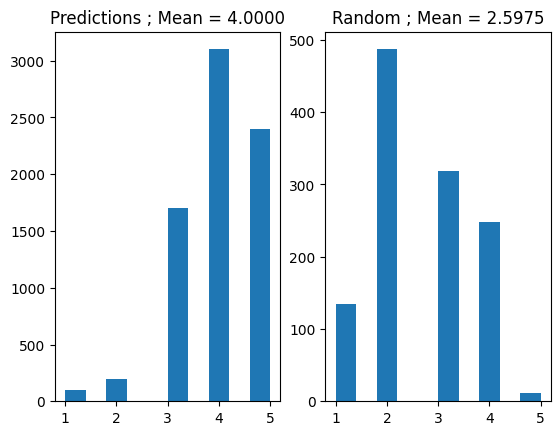

In [40]:
plt.subplot(1, 2, 1)
plt.hist(ratings_grouped_cosine)
plt.title('Predictions ; Mean = %.4f' % (np.mean(ratings_grouped_cosine)))
plt.subplot(1, 2, 2)
plt.hist(random_seen)
plt.title('Random ; Mean = %.4f' % (np.mean(random_seen)))
plt.show()

In [216]:
ratings_grouped_cosine_np = np.array(ratings_grouped_cosine)
print("Presicion for grouped cosine equals:", len(ratings_grouped_cosine_np[ratings_grouped_cosine_np==5])/len(ratings_grouped_cosine))

Presicion for grouped cosine equals: 0.4731182795698925


**GROUPED AVERAGE**

In [218]:
nb_episodes = 100

environment_with_average = Environment(data, embeddings, alpha, gamma, fixed_length, 'grouped average')

tf.reset_default_graph() 

sess = tf.Session()
actor_with_average = Actor(sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embeddings.size(), tau, actor_lr)
critic_with_average = Critic(sess, state_space_size, action_space_size, history_length, embeddings.size(), tau, critic_lr)

train(sess, environment, actor_with_average, critic_with_average, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary)

C:\Users\acted\AppData\Local\Temp\ipykernel_19152\3216367250.py:66: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.nn.rnn_cell.GRUCell(self.embedding_size,
C:\Users\acted\AppData\Local\Temp\ipykernel_19152\3176283722.py:61: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.nn.rnn_cell.GRUCell(self.history_length,


Episode 1/100 Reward=1103 Time=55s Loss=1989.4851
Episode 2/100 Reward=1103 Time=136s Loss=180.9150
Episode 3/100 Reward=1103 Time=136s Loss=85.9401
Episode 4/100 Reward=1103 Time=136s Loss=52.5294
Episode 5/100 Reward=1103 Time=136s Loss=39.7994
Episode 6/100 Reward=1103 Time=136s Loss=28.3001
Episode 7/100 Reward=1102 Time=136s Loss=21.5048
Episode 8/100 Reward=1102 Time=136s Loss=20.2219
Episode 9/100 Reward=1103 Time=136s Loss=15.0164
Episode 10/100 Reward=1103 Time=137s Loss=14.7910
Episode 11/100 Reward=1103 Time=136s Loss=14.1264
Episode 12/100 Reward=1103 Time=136s Loss=11.3927
Episode 13/100 Reward=1103 Time=136s Loss=10.7193
Episode 14/100 Reward=1103 Time=136s Loss=10.6064
Episode 15/100 Reward=1103 Time=136s Loss=9.4308
Episode 16/100 Reward=1103 Time=136s Loss=8.5487
Episode 17/100 Reward=1103 Time=135s Loss=7.8608
Episode 18/100 Reward=1103 Time=136s Loss=7.4674
Episode 19/100 Reward=1103 Time=136s Loss=7.1202
Episode 20/100 Reward=1103 Time=136s Loss=6.5345
Episode 21/10

In [ ]:
ratings_grouped_average, unknown_grouped_average, random_seen_average = test_actor(actor_with_average, dg.test, embeddings, dict_embeddings, ra_length, history_length, target=True, nb_rounds=10)
print('%0.1f%% unknown' % (100 * unknown_grouped_cosine / (len(ratings_grouped_cosine) + unknown_grouped_cosine)))

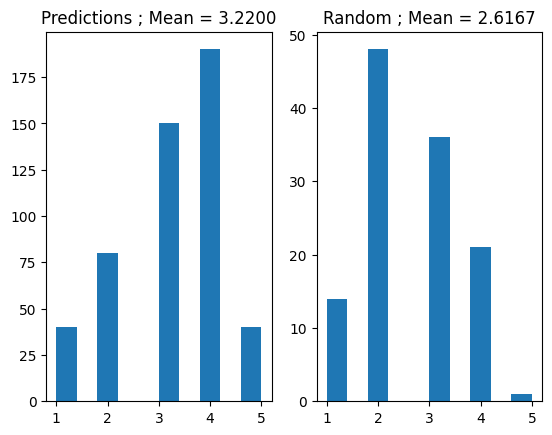

In [226]:
plt.subplot(1, 2, 1)
plt.hist(ratings_grouped_average)
plt.title('Predictions ; Mean = %.4f' % (np.mean(ratings_grouped_average)))
plt.subplot(1, 2, 2)
plt.hist(random_seen)
plt.title('Random ; Mean = %.4f' % (np.mean(random_seen_average)))
plt.show()

In [224]:
ratings_grouped_average = np.array(ratings_grouped_average)
print("Presicion for grouped cosine equals:", len(ratings_grouped_average[ratings_grouped_average==5])/len(ratings_grouped_average))

Presicion for grouped cosine equals: 0.08


**NORMAL**

In [219]:
nb_episodes = 100

environment_with_normal = Environment(data, embeddings, alpha, gamma, fixed_length, 'normal')

tf.reset_default_graph() 

sess = tf.Session()
actor_with_normal = Actor(sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embeddings.size(), tau, actor_lr)
critic_with_normal = Critic(sess, state_space_size, action_space_size, history_length, embeddings.size(), tau, critic_lr)

train(sess, environment, actor_with_normal, critic_with_normal, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary)

C:\Users\acted\AppData\Local\Temp\ipykernel_19152\3216367250.py:66: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.nn.rnn_cell.GRUCell(self.embedding_size,
C:\Users\acted\AppData\Local\Temp\ipykernel_19152\3176283722.py:61: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.nn.rnn_cell.GRUCell(self.history_length,


Episode 1/100 Reward=1103 Time=55s Loss=5116.2837
Episode 2/100 Reward=1103 Time=137s Loss=5589.3048
Episode 3/100 Reward=1103 Time=135s Loss=6624.2253
Episode 4/100 Reward=1103 Time=135s Loss=3016.3047
Episode 5/100 Reward=1103 Time=135s Loss=1768.9815
Episode 6/100 Reward=1103 Time=135s Loss=1490.5351
Episode 7/100 Reward=1103 Time=135s Loss=1162.9508
Episode 8/100 Reward=1103 Time=135s Loss=853.0841
Episode 9/100 Reward=1102 Time=136s Loss=901.1408
Episode 10/100 Reward=1103 Time=136s Loss=784.8940
Episode 11/100 Reward=1103 Time=136s Loss=610.1271
Episode 12/100 Reward=1102 Time=136s Loss=694.3025
Episode 13/100 Reward=1103 Time=136s Loss=566.9536
Episode 14/100 Reward=1103 Time=136s Loss=573.9618
Episode 15/100 Reward=1103 Time=136s Loss=440.7941
Episode 16/100 Reward=1103 Time=136s Loss=467.0823
Episode 17/100 Reward=1102 Time=136s Loss=445.9628
Episode 18/100 Reward=1102 Time=136s Loss=497.5534
Episode 19/100 Reward=1102 Time=136s Loss=448.1540
Episode 20/100 Reward=1102 Time=13

In [279]:
nb_episodes = 100

environment = Environment(data, embeddings, alpha, gamma, fixed_length)

tf.reset_default_graph()

sess = tf.Session()
actor = Actor(sess, state_space_size, action_space_size, batch_size, ra_length, history_length, embeddings.size(), tau, actor_lr)
critic = Critic(sess, state_space_size, action_space_size, history_length, embeddings.size(), tau, critic_lr)

q_values = train(sess, environment, actor, critic, embeddings, history_length, ra_length, buffer_size, batch_size, discount_factor, nb_episodes, filename_summary)

C:\Users\acted\AppData\Local\Temp\ipykernel_19152\3216367250.py:66: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.nn.rnn_cell.GRUCell(self.embedding_size,
C:\Users\acted\AppData\Local\Temp\ipykernel_19152\3176283722.py:61: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.nn.rnn_cell.GRUCell(self.history_length,


Episode 1/100 Reward=1103 Q_value=284 Time=57s Loss=2004.4739
Episode 2/100 Reward=1103 Q_value=1456 Time=140s Loss=253.2909
Episode 3/100 Reward=1103 Q_value=1320 Time=139s Loss=131.3465
Episode 4/100 Reward=1103 Q_value=1309 Time=139s Loss=106.2750
Episode 5/100 Reward=1103 Q_value=1295 Time=141s Loss=76.0727
Episode 6/100 Reward=1103 Q_value=1266 Time=141s Loss=61.7680
Episode 7/100 Reward=1104 Q_value=1244 Time=141s Loss=54.5945
Episode 8/100 Reward=1103 Q_value=1243 Time=136s Loss=47.5694
Episode 9/100 Reward=1103 Q_value=1237 Time=136s Loss=51.0134
Episode 10/100 Reward=1103 Q_value=1222 Time=136s Loss=50.0795
Episode 11/100 Reward=1103 Q_value=1223 Time=136s Loss=45.8127
Episode 12/100 Reward=1103 Q_value=1209 Time=136s Loss=38.7876
Episode 13/100 Reward=1103 Q_value=1198 Time=136s Loss=37.3134
Episode 14/100 Reward=1103 Q_value=1194 Time=136s Loss=31.5426
Episode 15/100 Reward=1103 Q_value=1182 Time=136s Loss=26.7227
Episode 16/100 Reward=1103 Q_value=1179 Time=136s Loss=23.623

In [282]:
result = []

for i in q_values:
    result.append(sum(i)/len(i))
result

[7.689645731771314,
 14.56360713005066,
 13.204024028778075,
 13.094490194320679,
 12.95264368057251,
 12.667470893859864,
 12.441733932495117,
 12.436055145263673,
 12.373600015640259,
 12.22006160736084,
 12.237611474990844,
 12.098869466781617,
 11.989648084640503,
 11.94323016166687,
 11.820572843551636,
 11.796512441635132,
 11.813572883605957,
 11.78307970046997,
 11.818162536621093,
 11.712055835723877,
 11.739630784988403,
 11.762462940216064,
 11.643428068161011,
 11.781381559371948,
 11.626701288223266,
 11.609566650390626,
 11.550229549407959,
 11.51326449394226,
 11.42892731666565,
 11.371025743484497,
 11.314921712875366,
 11.365211038589477,
 11.34806692123413,
 11.35084945678711,
 11.30423306465149,
 11.352422981262206,
 11.417527990341187,
 11.351434907913209,
 11.27599633216858,
 11.338545713424683,
 11.25947949409485,
 11.314146814346314,
 11.30631233215332,
 11.331237373352051,
 11.303279180526733,
 11.284408588409423,
 11.266418027877808,
 11.304393854141235,
 11.30